In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import annotations
import sys
sys.path.append('..')
from lib.plot import plot_iteration
from lib.gif import create_gif
import numpy as np
from pixel_individual import PixelIndividual
from pixel_population import Population
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
from tqdm.auto import tqdm

plt.rcParams['figure.facecolor'] = 'white'

np.set_printoptions(precision=3, suppress=True)

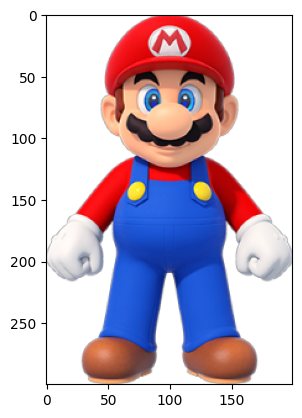

In [4]:
TARGET = image.imread('../targets/mario.png')
# TARGET = (TARGET[..., :3] * 256)
TARGET = cv2.resize(TARGET, (200, 300))
plt.imshow(TARGET)

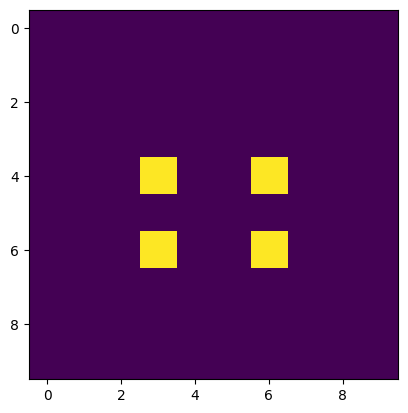

In [39]:
TARGET = np.zeros(shape=(10, 10))
TARGET[4, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
TARGET[6, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
plt.imshow(TARGET)

In [13]:
ind = PixelIndividual(shape=TARGET.shape)

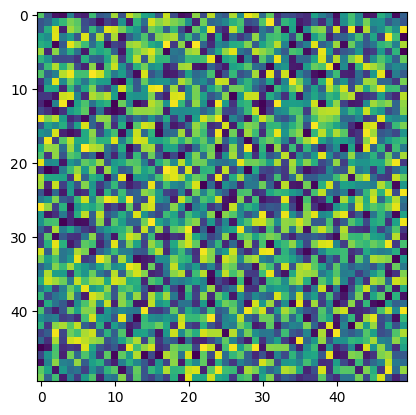

array([[ 0.001,  0.012, -0.002, -0.   ,  0.024,  0.013, -0.011,  0.016,
         0.003,  0.003, -0.024, -0.024, -0.017, -0.007, -0.015, -0.02 ,
         0.01 , -0.004,  0.01 , -0.011, -0.022,  0.018,  0.013, -0.018,
         0.01 , -0.021, -0.008,  0.013,  0.021, -0.025,  0.016, -0.019,
         0.019, -0.022, -0.002, -0.021,  0.014, -0.024, -0.014, -0.017,
         0.014, -0.009,  0.013,  0.011, -0.009,  0.006, -0.003, -0.003,
        -0.008, -0.003],
       [-0.018, -0.023,  0.017,  0.003, -0.024,  0.023, -0.022,  0.009,
         0.001, -0.016,  0.018,  0.011,  0.02 ,  0.024, -0.016,  0.008,
         0.003,  0.018,  0.001, -0.019,  0.004, -0.022,  0.015,  0.009,
         0.011, -0.002, -0.02 , -0.002, -0.022,  0.02 , -0.018,  0.004,
        -0.001,  0.011,  0.016,  0.004, -0.015, -0.008, -0.015,  0.006,
        -0.014, -0.   ,  0.025,  0.012, -0.024, -0.01 ,  0.002, -0.009,
        -0.016, -0.003]], dtype=float32)

In [14]:
ind = PixelIndividual(shape=TARGET.shape, mutate_prob=1)

ind.mutate()
ind.show()
ind.mutation[:2]

In [ ]:
pop = Population(popsize=5, target=TARGET)

## Run gridsearch experiment for suitable population and individual parameters

In [24]:
from typing import Dict, Any
from joblib import Parallel, delayed
from itertools import product
import pandas as pd
import plotly.express as px

mutation_delta = [0.1, 0.2, 0.3, 0.4]
mutation_prob = [0.1, 0.3, 0.5]
copy_top_perc = [0.02, 0.04, 0.08, 0.15]
sample_top_n = [0.1, 0.2, 0.05, 0.3, 0.4]
results = []

def optimize_with_config(mutation_delta, mutation_prob, copy_top_perc, sample_top_n) -> Dict[str, Any]:
    pop = Population(target=TARGET, popsize=30, mutation_delta=mutation_delta, mutation_prob=mutation_prob, copy_top_perc=copy_top_perc, sample_top_n=sample_top_n)
    pop.optimize(epochs=400, plot=False)
    return {
        'mutation_delta': mutation_delta, 
        'mutation_prob': mutation_prob, 
        'copy_top_perc': copy_top_perc, 
        'sample_top_n': sample_top_n, 
        'best_fitness': pop.pop[0].fitness
        }

In [25]:
param_combinations = list(product(mutation_delta, mutation_prob, copy_top_perc, sample_top_n))
result = Parallel(n_jobs=-1)(delayed(optimize_with_config)(mdelta, mprob, topp, topn) for mdelta, mprob, topp, topn in tqdm(param_combinations, total=len(param_combinations)))
results_df = pd.DataFrame(result)
results_df.to_parquet('grid_search_results.parquet')
results_df.head()

  0%|          | 0/240 [00:00<?, ?it/s]

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,best_fitness
0,0.1,0.1,0.02,0.10,469.089896
1,0.1,0.1,0.02,0.20,446.655820
2,0.1,0.1,0.02,0.05,514.730597
3,0.1,0.1,0.02,0.30,420.383905
4,0.1,0.1,0.02,0.40,386.919178


In [26]:
results_df = pd.read_parquet('grid_search_results.parquet')
results_df.sort_values('best_fitness')

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,best_fitness
39,0.1,0.3,0.15,0.40,378.537444
99,0.2,0.3,0.15,0.40,378.798450
54,0.1,0.5,0.08,0.40,380.867109
194,0.4,0.1,0.08,0.40,381.138741
34,0.1,0.3,0.08,0.40,382.284340
...,...,...,...,...,...
182,0.4,0.1,0.02,0.05,514.649624
2,0.1,0.1,0.02,0.05,514.730597
27,0.1,0.3,0.04,0.05,516.796636
52,0.1,0.5,0.08,0.05,517.420879


In [27]:
px.parallel_coordinates(results_df, color='best_fitness', labels=['mutation_delta', 'mutation_prob', 'copy_top_perc', 'sample_top_n', 'best_fitness'])

## Run full optimization 

### 4 Dots

In [41]:
pop = Population(target=TARGET, popsize=100, mutation_delta=0.4, mutation_prob=0.4, copy_top_perc=0.04, sample_top_n=0.4)
pop.optimize(epochs=200, plot_frequency=2, name='4dots', show=True, plot=True)

Output()

  0%|          | 0/200 [00:00<?, ?it/s]

![training gif](../img/4dots/training.gif)

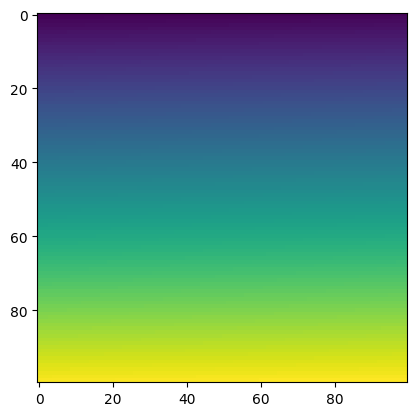

In [4]:
TARGET = np.arange(0, 1, 0.0001).reshape((100, 100))
plt.imshow(TARGET)

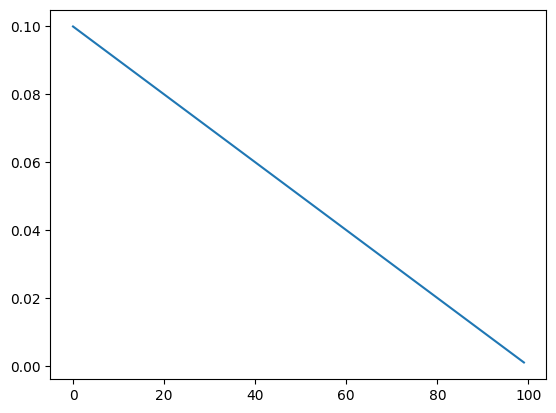

In [7]:
total_epochs = 100

plt.plot([0.1 * ((total_epochs - i) / total_epochs) for i in range(total_epochs)])

In [8]:
pop = Population(target=TARGET, popsize=100, mutation_delta=0.2, mutation_prob=0.4, copy_top_perc=0.04, sample_top_n=0.4, stop_threshold=0.001)
pop.optimize(epochs=10000, plot_frequency=20, name='gradient', show=True, plot=True)

Output()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
create_gif('img/gradient/iters', fp_out='img/gradient/training.gif')

Image saved at img/gradient/training.gif.


In [12]:
create_gif('../polygon/img/rick_polygons/iters', fp_out='../polygon/img/rick_polygons/training_gif.gif')

Image saved at ../polygon/img/rick_polygons/training_gif.gif.
